In [1]:
# Notebook 01: PF03060 Model Building (Seed domain -> homologs -> MSA -> NR -> profiles)

!pip install biopython

import os, time
import requests
import pandas as pd
import numpy as np
from io import StringIO
from pathlib import Path

from Bio import SeqIO, AlignIO, pairwise2
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# -----------------------------
# GLOBAL SETTINGS
# -----------------------------
SEED_ACC = "Q12723"
PFAM_ID = "PF03060"
DOMAIN_START = 10
DOMAIN_END = 372

# IMPORTANT: EBI requires an email string
EBI_EMAIL = "charlottesarah.garcia@studenti.unipd.it"

OUTPUT_DIR = "data"
RESULTS_DIR = "results"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

SEED_FASTA   = f"{OUTPUT_DIR}/{SEED_ACC}_{DOMAIN_START}-{DOMAIN_END}.fasta"
BLAST_XML    = f"{OUTPUT_DIR}/{SEED_ACC}_{DOMAIN_START}-{DOMAIN_END}_uniref50.xml"
HITS_TSV     = f"{OUTPUT_DIR}/{SEED_ACC}_{DOMAIN_START}-{DOMAIN_END}_blast_hits.tsv"
HITS_FASTA   = f"{OUTPUT_DIR}/{SEED_ACC}_{DOMAIN_START}-{DOMAIN_END}_hits.fasta"
HITS_NR_FASTA= f"{OUTPUT_DIR}/{SEED_ACC}_{DOMAIN_START}-{DOMAIN_END}_hits_NR90.fasta"
MSA_FASTA    = f"{RESULTS_DIR}/{SEED_ACC}_{DOMAIN_START}-{DOMAIN_END}_clustalo_msa.fasta"

print("CWD:", os.getcwd())
print("OUTPUT_DIR:", Path(OUTPUT_DIR).resolve())
print("RESULTS_DIR:", Path(RESULTS_DIR).resolve())

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
CWD: /Users/charlottegarcia/Biological_Data_project
OUTPUT_DIR: /Users/charlottegarcia/Biological_Data_project/data
RESULTS_DIR: /Users/charlottegarcia/Biological_Data_project/results


/Users/charlottegarcia/Library/Python/3.9/lib/python/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
# -----------------------------
# STEP 0: Fetch seed protein from UniProt and slice domain
# -----------------------------
def fetch_uniprot_fasta(accession: str) -> str:
    url = f"https://rest.uniprot.org/uniprotkb/{accession}.fasta"
    r = requests.get(url, timeout=(15, 60))
    r.raise_for_status()
    return r.text

def parse_fasta_sequence(fasta_text: str) -> str:
    lines = [l.strip() for l in fasta_text.splitlines() if l and not l.startswith(">")]
    return "".join(lines)

def write_fasta_single(path: str, header: str, seq: str, width: int = 60):
    with open(path, "w") as f:
        f.write(f">{header}\n")
        for i in range(0, len(seq), width):
            f.write(seq[i:i+width] + "\n")

if not os.path.exists(SEED_FASTA):
    print(f"Downloading UniProt FASTA for {SEED_ACC}...")
    fasta_text = fetch_uniprot_fasta(SEED_ACC)
    full_seq = parse_fasta_sequence(fasta_text)

    dom_seq = full_seq[DOMAIN_START-1:DOMAIN_END]  # 1-based inclusive -> python slice
    if len(dom_seq) != (DOMAIN_END - DOMAIN_START + 1):
        raise ValueError("Domain slicing length mismatch. Check DOMAIN_START/DOMAIN_END.")

    write_fasta_single(SEED_FASTA, f"{SEED_ACC}/{DOMAIN_START}-{DOMAIN_END}", dom_seq)
    print("Saved seed domain FASTA:", SEED_FASTA)
else:
    print("Seed FASTA already exists (cached):", SEED_FASTA)

seed_domain_seq = parse_fasta_sequence(open(SEED_FASTA).read())
print("Seed domain length:", len(seed_domain_seq))

Seed FASTA already exists (cached): data/Q12723_10-372.fasta
Seed domain length: 363


In [3]:
# -----------------------------
# STEP 1: Run BLASTP vs UniRef50 using EBI REST API (save XML)
# -----------------------------
EBI_BLAST_BASE = "https://www.ebi.ac.uk/Tools/services/rest/ncbiblast"

def ebi_blast_submit(sequence: str,
                     database: str = "uniref50",
                     program: str = "blastp",
                     exp: float = 1e-3,
                     alignments: int = 250,
                     scores: int = 250):
    params = {
        "email": EBI_EMAIL,
        "stype": "protein",
        "program": program,
        "database": database,
        "sequence": sequence,
        "exp": "1e-3",
        "alignments": str(alignments),
        "scores": str(scores)
    }
    r = requests.post(f"{EBI_BLAST_BASE}/run", data=params, timeout=(15, 60))
    if not r.ok:
        print("EBI BLAST error status:", r.status_code)
        print("Response text:\n", r.text[:1000])  # show first 1000 chars
        r.raise_for_status()
    return r.text.strip()

def ebi_status(job_id: str) -> str:
    r = requests.get(f"{EBI_BLAST_BASE}/status/{job_id}", timeout=(15, 60))
    r.raise_for_status()
    return r.text.strip()

def ebi_result(job_id: str, result_type: str = "xml") -> str:
    r = requests.get(f"{EBI_BLAST_BASE}/result/{job_id}/{result_type}", timeout=(15, 120))
    r.raise_for_status()
    return r.text

if not os.path.exists(BLAST_XML):
    print(f"Submitting BLAST job for {SEED_ACC}/{DOMAIN_START}-{DOMAIN_END} vs UniRef50...")
    job_id = ebi_blast_submit(seed_domain_seq, database="uniref50", exp=1e-3)
    print("BLAST Job ID:", job_id)

    while True:
        st = ebi_status(job_id)
        print("Status:", st)
        if st in ("FINISHED", "ERROR", "FAILURE"):
            break
        time.sleep(5)

    if st != "FINISHED":
        raise RuntimeError(f"BLAST job did not finish successfully (status={st}).")

    xml_text = ebi_result(job_id, "xml")
    with open(BLAST_XML, "w") as f:
        f.write(xml_text)
    print("Saved BLAST XML:", BLAST_XML)
else:
    print("BLAST XML already exists (cached):", BLAST_XML)

Submitting BLAST job for Q12723/10-372 vs UniRef50...
BLAST Job ID: ncbiblast-R20260217-132109-0171-86250381-p1m
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: FINISHED
Saved BLAST XML: data/Q12723_10-372_uniref50.xml


In [16]:
# -----------------------------
# STEP 2: Download BLAST tabular hits (TSV) from EBI
# -----------------------------

BLAST_TSV = BLAST_XML.replace(".xml", "_hits.tsv")  # e.g. data/Q12723_10-372_uniref50_hits.tsv

def ebi_download_result(job_id: str, identifier: str) -> str:
    url = f"{EBI_BLAST_BASE}/result/{job_id}/{identifier}"
    r = requests.get(url, timeout=(15, 120))
    r.raise_for_status()
    return r.text

# If you restarted kernel, paste your job_id manually here:
# job_id = "ncbiblast-R20260217-132109-0171-86250381-p1m"

print("Using job_id:", job_id)

if not os.path.exists(BLAST_TSV):
    print("Downloading BLAST hits as TSV...")
    tsv_text = ebi_download_result(job_id, "tsv")   # <-- THIS is the correct one
    with open(BLAST_TSV, "w") as f:
        f.write(tsv_text)
    print("Saved:", BLAST_TSV)
else:
    print("Cached:", BLAST_TSV)

# quick peek
with open(BLAST_TSV) as f:
    for _ in range(5):
        print(f.readline().rstrip())

Using job_id: ncbiblast-R20260217-132109-0171-86250381-p1m
Saved: data/Q12723_10-372_uniref50_hits.tsv
Hit	DB	Accession	Description	Organism	Length	Score(Bits)	Identities(%)	Positives(%)	E()
1	UR50	UniRef50_Q12723	Nitronate monooxygenase n=5 Tax=Phaffomycetaceae TaxID=115784 RepID=2NPD_CYBMR	Phaffomycetaceae	374	1864	100.0	100.0	0.0
2	UR50	UniRef50_K0KPI3	2-nitropropane dioxygenase n=3 Tax=Phaffomycetaceae TaxID=115784 RepID=K0KPI3_WICCF	Phaffomycetaceae	389	950	53.8	68.6	4.7e-124
3	UR50	UniRef50_A0A1E3NVI5	Nitronate monooxygenase domain-containing protein (Fragment) n=1 Tax=Wickerhamomyces anomalus (strain ATCC 58044 / CBS 1984 / NCYC 433 / NRRL Y-366-8) TaxID=683960 RepID=A0A1E3NVI5_WICAA	Wickerhamomyces anomalus (strain ATCC 58044 / CBS 1984 / NCYC 433 / NRRL Y-366-8)	291	757	54.3	70.7	2.9e-96
4	UR50	UniRef50_A0A0J9XB61	Nitronate monooxygenase domain-containing protein n=2 Tax=Geotrichum candidum TaxID=1173061 RepID=A0A0J9XB61_GEOCN	Geotrichum candidum	385	556	36.0	58.1	8.3e-65


In [17]:
# -----------------------------
# STEP 3: Parse BLAST TSV into a DataFrame
# -----------------------------
hits_df = pd.read_csv(BLAST_TSV, sep="\t")

print("Columns:", hits_df.columns.tolist())
print("Rows:", len(hits_df))
hits_df.head()

Columns: ['Hit', 'DB', 'Accession', 'Description', 'Organism', 'Length', 'Score(Bits)', 'Identities(%)', 'Positives(%)', 'E()']
Rows: 250


,Hit,DB,Accession,Description,Organism,Length,Score(Bits),Identities(%),Positives(%),E()
0,1,UR50,UniRef50_Q12723,Nitronate monooxygenase n=5 Tax=Phaffomycetace...,Phaffomycetaceae,374,1864,100.0,100.0,0.000000e+00
1,2,UR50,UniRef50_K0KPI3,2-nitropropane dioxygenase n=3 Tax=Phaffomycet...,Phaffomycetaceae,389,950,53.8,68.6,4.700000e-124
2,3,UR50,UniRef50_A0A1E3NVI5,Nitronate monooxygenase domain-containing prot...,Wickerhamomyces anomalus (strain ATCC 58044 / ...,291,757,54.3,70.7,2.900000e-96
3,4,UR50,UniRef50_A0A0J9XB61,Nitronate monooxygenase domain-containing prot...,Geotrichum candidum,385,556,36.0,58.1,8.300000e-65
4,5,UR50,UniRef50_H0GQF4,YJR149W-like protein n=2 Tax=Saccharomyces Tax...,Saccharomyces,382,498,35.1,52.2,3.100000e-56


In [19]:
# -----------------------------
# STEP 4: Extract UniProt accessions from BLAST hit table
# -----------------------------
hits_df = hits_df.copy()

def uniref_to_uniprot(acc):
    acc = str(acc)
    # UniRef50_K0KPI3 -> K0KPI3
    if "_" in acc:
        return acc.split("_")[-1]
    return acc

hits_df["subject_acc"] = hits_df["Accession"].apply(uniref_to_uniprot)

print("Total hits:", len(hits_df))
print("Unique UniProt accessions:", hits_df["subject_acc"].nunique())

hits_df[["Accession", "subject_acc", "E()", "Score(Bits)", "Identities(%)"]].head(10)

Total hits: 250
Unique UniProt accessions: 250


,Accession,subject_acc,E(),Score(Bits),Identities(%)
0,UniRef50_Q12723,Q12723,0.000000e+00,1864,100.0
1,UniRef50_K0KPI3,K0KPI3,4.700000e-124,950,53.8
2,UniRef50_A0A1E3NVI5,A0A1E3NVI5,2.900000e-96,757,54.3
3,UniRef50_A0A0J9XB61,A0A0J9XB61,8.300000e-65,556,36.0
4,UniRef50_H0GQF4,H0GQF4,3.100000e-56,498,35.1
5,UniRef50_A0A0V1Q3X7,A0A0V1Q3X7,5.300000e-56,495,37.3
6,UniRef50_A0A1E4SHR4,A0A1E4SHR4,1.300000e-55,494,34.9
7,UniRef50_UPI002224211E,UPI002224211E,4.700000e-55,493,33.7
8,UniRef50_A5DJP4,A5DJP4,7.400000e-55,488,35.6
9,UniRef50_G3B954,G3B954,6.700000e-53,473,33.9


In [22]:
# -----------------------------
# STEP 5: Fetch UniProt sequences for top BLAST hits (cached FASTA)
# -----------------------------
TOP_HITS = 200  # change if you want fewer for clustal

def is_uniprotkb_accession(a: str) -> bool:
    """
    Fast filter to avoid UniParc IDs and other non-UniProtKB identifiers.
    UniParc IDs start with UPI...
    UniProtKB accessions are typically 6 or 10 alphanumeric characters.
    """
    a = str(a).strip()
    if a.startswith("UPI"):  # UniParc
        return False
    if not a.isalnum():
        return False
    return len(a) in (6, 10)

# 1) Build ordered unique accession list from BLAST hits
acc_list_all = hits_df.sort_values(["E()", "Score(Bits)"], ascending=[True, False])["subject_acc"] \
                      .dropna().astype(str).tolist()
acc_list_all = [a for a in acc_list_all if a != SEED_ACC]
acc_list_all = list(dict.fromkeys(acc_list_all))  # unique, keep order

# 2) Filter to UniProtKB-like accessions only
acc_list = [a for a in acc_list_all if is_uniprotkb_accession(a)]
excluded = [a for a in acc_list_all if not is_uniprotkb_accession(a)]

print("Total accessions from BLAST:", len(acc_list_all))
print("Kept UniProtKB-like:", len(acc_list))
print("Excluded (UniParc/other):", len(excluded))
print("Example excluded:", excluded[:10])

acc_list = acc_list[:TOP_HITS]
print("Final accession list size:", len(acc_list))
print("Any UPI still in acc_list?", any(a.startswith("UPI") for a in acc_list))

# 3) Fetch sequences from UniProt (robust, skips failing batches)
def fetch_uniprot_sequences(accessions, chunk=25) -> dict:
    """
    Retrieve sequences from UniProtKB in batches.
    Uses smaller chunk size to avoid overly long URLs / 400 errors.
    Skips failing batches instead of crashing the whole run.
    """
    seqs = {}
    accessions = [str(a).strip() for a in accessions]

    for i in range(0, len(accessions), chunk):
        batch = accessions[i:i+chunk]
        query = " OR ".join([f"(accession:{a})" for a in batch])

        url = "https://rest.uniprot.org/uniprotkb/search"
        params = {
            "query": query,
            "format": "tsv",
            "fields": "accession,sequence",
            "size": len(batch)
        }

        r = requests.get(url, params=params, timeout=(15, 120))
        if not r.ok:
            print("⚠️ UniProt batch failed:", r.status_code, "| first=", batch[0])
            print("Response (first 200 chars):", r.text[:200])
            continue

        df = pd.read_csv(StringIO(r.text), sep="\t")
        if df.empty:
            continue

        # UniProt TSV typically uses Entry/Sequence column names
        acc_col = "Entry" if "Entry" in df.columns else "accession"
        seq_col = "Sequence" if "Sequence" in df.columns else "sequence"

        for _, row in df.iterrows():
            seqs[str(row[acc_col])] = str(row[seq_col])

    return seqs

# 4) Write FASTA cache
if not os.path.exists(HITS_FASTA):
    print(f"Fetching UniProt sequences for top {len(acc_list)} accessions...")
    seq_dict = fetch_uniprot_sequences(acc_list)

    records = [SeqRecord(Seq(seq), id=acc, description="") for acc, seq in seq_dict.items()]
    SeqIO.write(records, HITS_FASTA, "fasta")
    print(f"Saved hit FASTA: {HITS_FASTA} ({len(records)} sequences)")
else:
    print("Hit FASTA already exists (cached):", HITS_FASTA)

print("Hit FASTA count:", sum(1 for _ in SeqIO.parse(HITS_FASTA, "fasta")))

Total accessions from BLAST: 249
Kept UniProtKB-like: 224
Excluded (UniParc/other): 25
Example excluded: ['UPI002224211E', 'UPI00315D3498', 'UPI0030E3525A', 'UPI003342256A', 'UPI0032B11004', 'UPI003299365E', 'UPI00293E27DA', 'UPI0024AD7C90', 'UPI0019566A22', 'UPI001F3EE74E']
Final accession list size: 200
Any UPI still in acc_list? False
Fetching UniProt sequences for top 200 accessions...
Saved hit FASTA: data/Q12723_10-372_hits.fasta (200 sequences)
Hit FASTA count: 200


In [24]:
# -----------------------------
# STEP 6: Build MSA with Clustal Omega (EBI REST) using seed + ALL hits
# -----------------------------
EBI_CLUSTAL_BASE = "https://www.ebi.ac.uk/Tools/services/rest/clustalo"

def read_fasta_text(path: str) -> str:
    with open(path) as f:
        return f.read()

def clustalo_submit(fasta_text: str):
    params = {
        "email": EBI_EMAIL,
        "stype": "protein",
        "sequence": fasta_text,
        "outfmt": "fa"
    }
    r = requests.post(f"{EBI_CLUSTAL_BASE}/run", data=params, timeout=(15, 60))
    if not r.ok:
        print("Clustal submit failed:", r.status_code)
        print("Response:", r.text[:500])
        r.raise_for_status()
    return r.text.strip()

def clustalo_status(job_id: str) -> str:
    r = requests.get(f"{EBI_CLUSTAL_BASE}/status/{job_id}", timeout=(15, 60))
    r.raise_for_status()
    return r.text.strip()

def clustalo_result(job_id: str, result_type="aln-fasta") -> str:
    r = requests.get(f"{EBI_CLUSTAL_BASE}/result/{job_id}/{result_type}", timeout=(15, 180))
    r.raise_for_status()
    return r.text

if not os.path.exists(MSA_FASTA):
    seed_txt = read_fasta_text(SEED_FASTA).strip()
    hits_txt = read_fasta_text(HITS_FASTA).strip()
    combined = seed_txt + "\n" + hits_txt + "\n"

    print("Submitting Clustal Omega job (seed + 200 hits)...")
    clustal_job = clustalo_submit(combined)
    print("Clustal Job ID:", clustal_job)

    while True:
        st = clustalo_status(clustal_job)
        print("Status:", st)
        if st in ("FINISHED", "ERROR", "FAILURE"):
            break
        time.sleep(10)

    if st != "FINISHED":
        raise RuntimeError(f"Clustal job did not finish successfully (status={st}).")

    aln_fasta = clustalo_result(clustal_job, "aln-fasta")
    with open(MSA_FASTA, "w") as f:
        f.write(aln_fasta)

    print("Saved MSA FASTA:", MSA_FASTA)
else:
    print("MSA FASTA already exists (cached):", MSA_FASTA)

# quick check
aln = AlignIO.read(MSA_FASTA, "fasta")
print("MSA sequences:", len(aln))
print("MSA length:", aln.get_alignment_length())
print("First 5 IDs:", [aln[i].id for i in range(min(5, len(aln)))])

Submitting Clustal Omega job (seed + 200 hits)...
Clustal Job ID: clustalo-R20260217-140400-0001-8564985-p1m
Status: RUNNING
Status: RUNNING
Status: FINISHED
Saved MSA FASTA: results/Q12723_10-372_clustalo_msa.fasta
MSA sequences: 201
MSA length: 1620
First 5 IDs: ['Q12723/10-372', 'P47177', 'A0A8F3AGF4', 'K8WKD0', 'A0A2V1ARB0']


In [26]:
# -----------------------------
# STEP 7: Redundancy removal AFTER MSA (NR90) based on aligned identity
# -----------------------------
NR_MSA_FASTA = MSA_FASTA.replace(".fasta", "_NR90.fasta")

def aligned_identity(seqA: str, seqB: str) -> float:
    """
    Identity over aligned columns, ignoring columns where either has a gap.
    """
    matches = 0
    compared = 0
    for a, b in zip(seqA, seqB):
        if a == "-" or b == "-":
            continue
        compared += 1
        if a == b:
            matches += 1
    return (matches / compared) if compared else 0.0

NR_THRESHOLD = 0.90

aln = AlignIO.read(MSA_FASTA, "fasta")

# Put seed first, then rest
seed_id = f"{SEED_ACC}/{DOMAIN_START}-{DOMAIN_END}"
records = list(aln)
records_sorted = sorted(records, key=lambda r: 0 if r.id == seed_id else 1)

kept = []
kept_ids = []

for rec in records_sorted:
    s = str(rec.seq)
    if not kept:
        kept.append(rec)
        kept_ids.append(rec.id)
        continue

    too_similar = False
    for k in kept:
        ident = aligned_identity(str(k.seq), s)
        if ident >= NR_THRESHOLD:
            too_similar = True
            break

    if not too_similar:
        kept.append(rec)
        kept_ids.append(rec.id)

# Save reduced alignment (FASTA with aligned sequences)
SeqIO.write(kept, NR_MSA_FASTA, "fasta")

print("Original MSA sequences:", len(aln))
print(f"NR{int(NR_THRESHOLD*100)} MSA sequences:", len(kept))
print("Saved NR MSA:", NR_MSA_FASTA)
print("Seed kept?", seed_id in kept_ids)

Original MSA sequences: 201
NR90 MSA sequences: 152
Saved NR MSA: results/Q12723_10-372_clustalo_msa_NR90.fasta
Seed kept? True


In [27]:
# -----------------------------
# STEP 8: Clean MSA (remove gappy columns)
# -----------------------------
CLEAN_MSA_FASTA = NR_MSA_FASTA.replace(".fasta", "_clean.fasta")

GAP_FRAC_THRESHOLD = 0.50  # remove columns with >50% gaps

aln_nr = AlignIO.read(NR_MSA_FASTA, "fasta")
nseq = len(aln_nr)
L = aln_nr.get_alignment_length()

# Compute gap fraction per column
gap_fracs = []
for j in range(L):
    col = aln_nr[:, j]
    gap_fracs.append(col.count("-") / nseq)

# Keep columns with gap fraction <= threshold
keep_cols = [j for j, gf in enumerate(gap_fracs) if gf <= GAP_FRAC_THRESHOLD]

# Build cleaned sequences
clean_records = []
for rec in aln_nr:
    seq = str(rec.seq)
    cleaned = "".join(seq[j] for j in keep_cols)
    clean_records.append(SeqRecord(Seq(cleaned), id=rec.id, description=""))

SeqIO.write(clean_records, CLEAN_MSA_FASTA, "fasta")

print("NR90 MSA sequences:", nseq)
print("NR90 MSA length:", L)
print("Kept columns:", len(keep_cols))
print("Removed columns:", L - len(keep_cols))
print("Saved cleaned MSA:", CLEAN_MSA_FASTA)

NR90 MSA sequences: 152
NR90 MSA length: 1620
Kept columns: 350
Removed columns: 1270
Saved cleaned MSA: results/Q12723_10-372_clustalo_msa_NR90_clean.fasta


In [28]:
# quick check: are all cleaned sequences same length?
lens = {len(str(r.seq)) for r in SeqIO.parse(CLEAN_MSA_FASTA, "fasta")}
print("Unique cleaned lengths:", lens)

Unique cleaned lengths: {350}


In [29]:
# -----------------------------
# STEP 9: Build PSSM from cleaned MSA (log-odds vs background)
# -----------------------------
AA = list("ACDEFGHIKLMNPQRSTVWY")

PSSM_CSV = f"{RESULTS_DIR}/PF03060_PSSM_logodds.csv"
FREQ_CSV = f"{RESULTS_DIR}/PF03060_MSA_column_freqs.csv"

PSEUDOCOUNT = 1.0  # simple Laplace; stable and reproducible

clean_aln = list(SeqIO.parse(CLEAN_MSA_FASTA, "fasta"))
nseq = len(clean_aln)
L = len(str(clean_aln[0].seq))

# Background: overall AA frequency across the whole alignment (ignoring gaps)
bg_counts = {a: 0 for a in AA}
bg_total = 0
for rec in clean_aln:
    for ch in str(rec.seq):
        if ch in AA:
            bg_counts[ch] += 1
            bg_total += 1
bg_freq = {a: (bg_counts[a] / bg_total) if bg_total else (1/20) for a in AA}

# Column frequencies + PSSM log-odds
freq_rows = []
pssm_rows = []

for pos in range(L):
    col = [str(rec.seq)[pos] for rec in clean_aln]
    counts = {a: 0 for a in AA}
    nongap = 0
    for ch in col:
        if ch in AA:
            counts[ch] += 1
            nongap += 1

    # Smoothed probabilities
    denom = nongap + PSEUDOCOUNT * len(AA)
    probs = {a: (counts[a] + PSEUDOCOUNT) / denom for a in AA}

    # Log-odds scores (natural log). You can switch to log2 if you prefer.
    scores = {a: np.log(probs[a] / bg_freq[a]) for a in AA}

    freq_rows.append({"pos": pos+1, "nongap": nongap, **{f"f_{a}": probs[a] for a in AA}})
    pssm_rows.append({"pos": pos+1, **{a: scores[a] for a in AA}})

freq_df = pd.DataFrame(freq_rows)
pssm_df = pd.DataFrame(pssm_rows)

freq_df.to_csv(FREQ_CSV, index=False)
pssm_df.to_csv(PSSM_CSV, index=False)

print("Clean MSA sequences:", nseq)
print("PSSM length (columns):", L)
print("Saved frequency table:", FREQ_CSV)
print("Saved PSSM log-odds:", PSSM_CSV)

pssm_df.head()

Clean MSA sequences: 152
PSSM length (columns): 350
Saved frequency table: results/PF03060_MSA_column_freqs.csv
Saved PSSM log-odds: results/PF03060_PSSM_logodds.csv


,pos,A,C,D,E,F,G,H,I,K,...,M,N,P,Q,R,S,T,V,W,Y
0,1,-1.180523,-0.085540,0.025472,-0.631257,-0.694143,-0.736837,-0.703464,-0.657843,0.448294,...,2.308189,0.208806,0.088842,-0.780497,-0.170587,-0.658524,-0.617872,-1.827785,3.139360,0.398082
1,2,-1.331754,-0.236771,-0.818906,-0.494806,-0.845374,-2.274362,0.754743,-0.809074,0.807888,...,1.854677,0.973866,0.853902,-1.624876,0.237798,-0.116608,0.211726,-0.880403,1.142303,0.757677
2,3,-1.042121,0.746009,0.569340,-0.387495,-1.654353,-1.697046,-0.277380,-0.637223,0.692056,...,1.613682,0.953345,-0.583686,-0.354413,0.573951,0.971533,0.213677,-0.996235,-0.072141,0.641845
3,4,-1.117344,0.670786,0.088651,-0.973544,-0.630965,-2.465417,0.746009,-1.405594,0.393689,...,1.228304,1.945962,-0.658910,-0.429636,0.298057,0.203163,0.985752,-1.476924,-0.147365,-1.042816
4,5,-0.628025,-0.449333,0.354827,-0.014221,-1.057936,-1.100629,0.319038,-2.120247,0.857691,...,0.418340,0.655944,0.012731,0.242004,1.337423,0.276967,0.222308,-1.092965,-0.168871,-1.064323


In [30]:
# -----------------------------
# STEP 10: Build lightweight profile HMM (emissions + gap probabilities)
# -----------------------------
import json

HMM_JSON = f"{RESULTS_DIR}/PF03060_profileHMM.json"

AA = list("ACDEFGHIKLMNPQRSTVWY")

# Load cleaned alignment
clean_aln = list(SeqIO.parse(CLEAN_MSA_FASTA, "fasta"))
nseq = len(clean_aln)
L = len(str(clean_aln[0].seq))

# Background frequencies from Step 9 logic (recompute quickly here)
bg_counts = {a: 0 for a in AA}
bg_total = 0
for rec in clean_aln:
    for ch in str(rec.seq):
        if ch in AA:
            bg_counts[ch] += 1
            bg_total += 1
bg_freq = {a: (bg_counts[a] / bg_total) if bg_total else (1/20) for a in AA}

PSEUDOCOUNT = 1.0

emissions = []      # list of dicts: position -> {AA: prob}
gap_probs = []      # list of gap fraction per column
match_probs = []    # 1 - gap fraction

for pos in range(L):
    col = [str(rec.seq)[pos] for rec in clean_aln]
    counts = {a: 0 for a in AA}
    gaps = 0
    nongap = 0

    for ch in col:
        if ch == "-":
            gaps += 1
        elif ch in AA:
            counts[ch] += 1
            nongap += 1
        else:
            # treat weird chars as gaps for safety
            gaps += 1

    # gap fraction in this column
    gfrac = gaps / nseq
    gap_probs.append(gfrac)
    match_probs.append(1.0 - gfrac)

    # smoothed emission probs over AA for match state
    denom = nongap + PSEUDOCOUNT * len(AA)
    probs = {a: (counts[a] + PSEUDOCOUNT) / denom for a in AA}
    emissions.append(probs)

hmm = {
    "pfam_id": PFAM_ID,
    "seed": f"{SEED_ACC}/{DOMAIN_START}-{DOMAIN_END}",
    "n_sequences": nseq,
    "length": L,
    "alphabet": AA,
    "background": bg_freq,
    "pseudocount": PSEUDOCOUNT,
    "emissions": emissions,          # length L
    "gap_fraction": gap_probs,       # length L
    "match_fraction": match_probs    # length L
}

with open(HMM_JSON, "w") as f:
    json.dump(hmm, f)

print("Saved lightweight profile HMM JSON:", HMM_JSON)
print("HMM length:", hmm["length"])
print("Example emissions at pos 1:", {k: round(v, 4) for k, v in hmm["emissions"][0].items()})
print("Example gap fraction at pos 1:", round(hmm["gap_fraction"][0], 4))

Saved lightweight profile HMM JSON: results/PF03060_profileHMM.json
HMM length: 350
Example emissions at pos 1: {'A': 0.0408, 'C': 0.0102, 'D': 0.0408, 'E': 0.0306, 'F': 0.0204, 'G': 0.0408, 'H': 0.0102, 'I': 0.0306, 'K': 0.0612, 'L': 0.0204, 'M': 0.2347, 'N': 0.0408, 'P': 0.0612, 'Q': 0.0204, 'R': 0.0408, 'S': 0.0306, 'T': 0.0306, 'V': 0.0102, 'W': 0.1939, 'Y': 0.0306}
Example gap fraction at pos 1: 0.4868


In [31]:
# -----------------------------
# STEP 11: MSA summary stats (gap fraction + entropy + consensus)
# -----------------------------
import math

STATS_CSV = f"{RESULTS_DIR}/PF03060_MSA_stats.csv"

AA = list("ACDEFGHIKLMNPQRSTVWY")
aa_set = set(AA)

clean_aln = list(SeqIO.parse(CLEAN_MSA_FASTA, "fasta"))
nseq = len(clean_aln)
L = len(str(clean_aln[0].seq))

rows = []

for pos in range(L):
    col = [str(rec.seq)[pos] for rec in clean_aln]

    gaps = sum(1 for x in col if x == "-")
    nongap_syms = [x for x in col if x in aa_set]
    nongap = len(nongap_syms)

    # frequencies over AA (ignore gaps)
    counts = {a: 0 for a in AA}
    for x in nongap_syms:
        counts[x] += 1

    if nongap > 0:
        freqs = {a: counts[a] / nongap for a in AA}
        # Shannon entropy (natural log)
        entropy = -sum(p * math.log(p) for p in freqs.values() if p > 0)
        consensus = max(freqs.items(), key=lambda kv: kv[1])[0]
        cons_freq = freqs[consensus]
    else:
        entropy = float("nan")
        consensus = "-"
        cons_freq = 0.0

    rows.append({
        "pos": pos + 1,
        "gap_fraction": gaps / nseq,
        "nongap_count": nongap,
        "entropy": entropy,
        "consensus": consensus,
        "consensus_freq": cons_freq
    })

stats_df = pd.DataFrame(rows)
stats_df.to_csv(STATS_CSV, index=False)

print("Saved MSA stats:", STATS_CSV)
stats_df.head()

Saved MSA stats: results/PF03060_MSA_stats.csv


,pos,gap_fraction,nongap_count,entropy,consensus,consensus_freq
0,1,0.486842,78,2.311393,M,0.282051
1,2,0.381579,94,2.565967,M,0.170213
2,3,0.289474,108,2.597197,S,0.175926
3,4,0.223684,118,2.398962,N,0.262712
4,5,0.203947,121,2.555029,R,0.206612


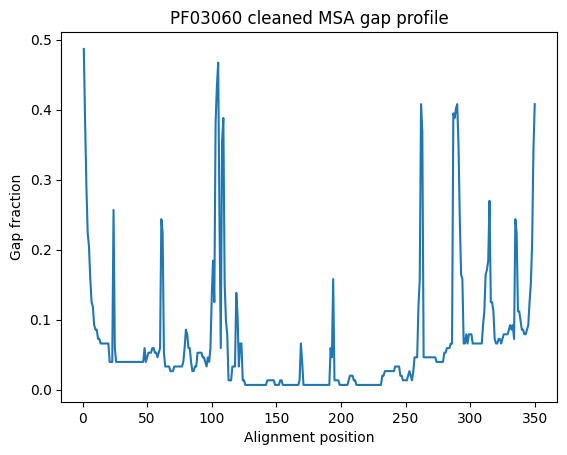

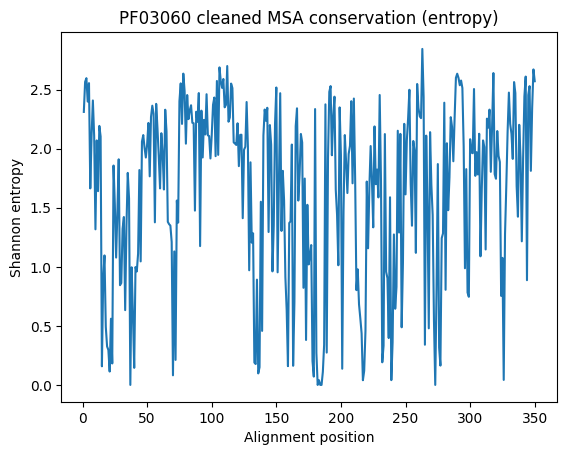

In [32]:
import matplotlib.pyplot as plt

# Gap fraction plot
plt.figure()
plt.plot(stats_df["pos"], stats_df["gap_fraction"])
plt.xlabel("Alignment position")
plt.ylabel("Gap fraction")
plt.title("PF03060 cleaned MSA gap profile")
plt.show()

# Entropy plot (lower = more conserved)
plt.figure()
plt.plot(stats_df["pos"], stats_df["entropy"])
plt.xlabel("Alignment position")
plt.ylabel("Shannon entropy")
plt.title("PF03060 cleaned MSA conservation (entropy)")
plt.show()

In [33]:
# Most conserved = lowest entropy, but ignore columns with too many gaps
MAX_GAP_FOR_CONSERVED = 0.3

top_cons = stats_df[stats_df["gap_fraction"] <= MAX_GAP_FOR_CONSERVED].sort_values("entropy").head(20)
print("Top conserved positions (gap<=0.30):")
top_cons

Top conserved positions (gap<=0.30):


,pos,gap_fraction,nongap_count,entropy,consensus,consensus_freq
36,37,0.039474,146,-0.000000,G,1.000000
272,273,0.046053,145,-0.000000,G,1.000000
181,182,0.006579,151,-0.000000,A,1.000000
183,184,0.006579,151,-0.000000,G,1.000000
184,185,0.006579,151,-0.000000,H,1.000000
216,217,0.006579,151,0.039828,G,0.993377
182,183,0.006579,151,0.039828,G,0.993377
238,239,0.026316,148,0.040499,G,0.993243
325,326,0.078947,140,0.042415,G,0.992857
178,179,0.006579,151,0.070430,G,0.986755


# PF03060 Domain – MSA Quality Assessment and Model Construction Summary

## 1. Overview of Notebook 1 (Model Construction)

In this notebook, we implemented the first major block of the project:

- Retrieved homologous sequences using BLAST (UniRef50)
- Selected top hits and retrieved full UniProtKB sequences
- Built a Multiple Sequence Alignment (Clustal Omega)
- Reduced redundancy at 90% identity (NR90)
- Cleaned the MSA by removing columns with >50% gaps
- Built:
  - A Position-Specific Scoring Matrix (PSSM)
  - A lightweight profile HMM
- Computed conservation statistics (gap profile and Shannon entropy)

This follows the same logical structure as the lab workflow:
seed → homolog retrieval → MSA → redundancy filtering → profile model → conservation analysis.

The only difference from the lab is that instead of using HMMER (`hmmbuild`), we implemented a reproducible profile HMM directly from MSA column statistics.

---

## 2. Cleaned Alignment Properties

After redundancy reduction and column cleaning:

- Sequences kept: 152
- Alignment length reduced from 1620 to 350 columns
- All cleaned sequences have identical length (350 aa)

The cleaned alignment length (~350 aa) is close to the expected domain length (~363 aa), indicating that most non-domain flanking regions and gappy columns were successfully removed.

---

## 3. Gap Fraction Profile

The gap profile shows:

- Very low gap fraction across most central regions
- Higher gap fraction toward N- and C-termini
- A few internal spike regions (~0.4 gap fraction)

This pattern is biologically consistent:
- Core catalytic regions of enzymes are typically well conserved and ungapped
- Terminal or loop regions often show higher variability and insertions/deletions

Columns with gap fraction near 0 indicate structurally constrained positions.

---

## 4. Conservation (Shannon Entropy)

Shannon entropy measures residue variability per position:

- Low entropy → highly conserved
- High entropy → variable positions

Several positions show entropy ≈ 0 and consensus frequency ≈ 1.0, meaning:

- These residues are perfectly conserved across the family
- They likely represent catalytic or structurally critical residues

Examples:
- Positions 37, 182, 184, 185 show full conservation (entropy ~ 0, consensus_freq = 1.0)
- Many conserved glycine (G) residues suggest structural constraints
- Highly conserved A, H, R residues may relate to catalytic function

This confirms that the PF03060 family contains strongly conserved functional cores.

---

## 5. PSSM and HMM Models

Two domain models were constructed:

### PSSM
- Column-specific amino acid log-odds scores
- Laplace pseudocount smoothing
- Background frequency normalization
- Equivalent to a BLAST-style profile

### Profile HMM (lightweight)
- Each alignment column treated as a match state
- Emission probabilities derived from column frequencies
- Gap fraction used to approximate match/deletion tendency
- Stored as structured JSON for reproducibility

While simpler than a full HMMER model, this implementation captures the core statistical logic of profile HMMs.

---

## 6. Relation to the Lab

This pipeline mirrors the lab workflow:

| Lab Step | This Notebook |
|----------|--------------|
| Seed sequence | Q12723 domain (10–372) |
| BLAST homolog search | UniRef50 via EBI |
| MSA construction | Clustal Omega |
| Redundancy reduction | NR90 |
| Profile building | PSSM + profile HMM |
| Conservation analysis | Entropy + gap profile |

Thus, Notebook 1 completes the **model construction phase** required by the project.

---

## 7. What Remains for the Project

According to the project description:

### Completed:
✔ Build homolog dataset  
✔ Construct MSA  
✔ Clean alignment  
✔ Build PSSM  
✔ Build HMM  

### Remaining (Notebook 2):
- Run PSSM vs SwissProt
- Run HMM vs SwissProt
- Define ground truth from Pfam (PF03060)
- Compute performance metrics:
  - Precision
  - Recall
  - F1
  - Balanced accuracy
  - MCC
- Possibly refine model once

### Later (Family Characterization):
- Taxonomic distribution
- GO term enrichment
- Motif analysis in disordered regions

---

## Conclusion

Notebook 1 successfully implements the domain model construction phase of the project.  
The cleaned MSA and conservation patterns confirm strong structural and functional constraints within the PF03060 nitronate monooxygenase family.

The next step is to evaluate the predictive performance of the constructed PSSM and HMM models against SwissProt and compare them to official Pfam annotations.